In [4]:
PATH="D:\\Instagram\\instagram-data\\"

In [10]:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
import os
import json
import re
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import seaborn as sns
import random as rand

In [16]:
print("Reading file is in progress")
Text=[]
Username=[]

for i in os.listdir(PATH):
    
    file=PATH+i+"\\"
    if(os.path.isdir(file)):
        for j in os.listdir(file):
                types=os.path.splitext(file+j)[1]
                if(types==".json" and file+j==PATH+i+"\\"+i+".json"):
                    with open(file+j, encoding="utf8") as json_file:  
                        data = json.load(json_file)
                        for datas in data:
                            for items in datas["edge_media_to_caption"]["edges"]:
                                Text.append(items.get("node").get("text"))
                                Username.append(i)
                                
survey=pd.read_csv("D:\\Instagram\\User_Category.csv")                             
survey.index=survey.User
print("Reading file is completed")

Reading file is in progress
Reading file is completed


In [22]:
survey=pd.read_csv("D:\\Instagram\\User_Category.csv")                             
survey.index=survey.User
Text_Metric=pd.DataFrame({"UserName":Username,"Text":Text})
Text_Metric.index=Text_Metric.UserName
TextCategory=pd.merge(survey,Text_Metric, left_on='User',right_index=True, how='inner')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: FutureWarning: 'User' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
Text = TextCategory.Text
category=TextCategory.Category

In [30]:
Text = list(map(lambda x: re.sub('[^\w]', " ", x), Text))
#Text = list(map(lambda x: re.sub('[\d]', " ", x), Stage1))
#category=['a','b','c','a','b']

In [32]:
df=pd.DataFrame({'Type':category,'Text':Text})
#Remove Nulls
df = df[pd.notnull(df['Type'])]
#Factorizing
df['category_id'] = df['Type'].factorize()[0]
category_id_df = df[['Type','category_id' ]].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Type']].values)

df.head()

,Type,Text,category_id
User,,,
_charlinchen,Conscientiousness,Palm trees and you that s all I need right no...,0
_charlinchen,Conscientiousness,Step by step rio riodejaneiro ...,0
_charlinchen,Conscientiousness,Don t go chasing waterfalls iguazu ...,0
_charlinchen,Conscientiousness,to the moon and back uyunisaltfla...,0
_charlinchen,Conscientiousness,Salt flat Uyuni saltflats saltdeser...,0


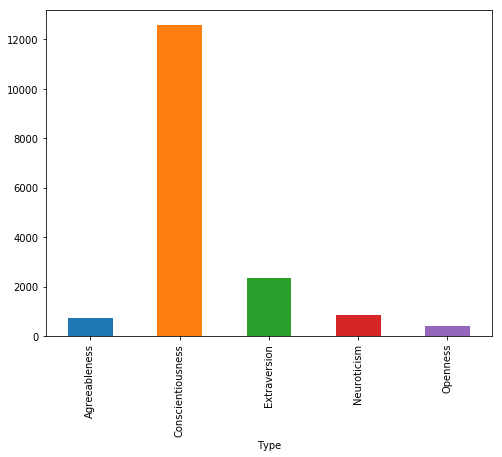

In [33]:
#Number of Posts
fig = plt.figure(figsize=(8,6))
df.groupby('Type').Text.count().plot.bar(ylim=0)
plt.show()


In [35]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.category_id

In [36]:
sorted(category_to_id.items())

[('Agreeableness', 3),
 ('Conscientiousness', 0),
 ('Extraversion', 1),
 ('Neuroticism', 2),
 ('Openness', 4)]

In [37]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category_id))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '3':
  . Most correlated unigrams:
. vapeon
. indonesia
  . Most correlated bigrams:
. dreampony maya
. galaxys8 samsungphotography
# '0':
  . Most correlated unigrams:
. berlinstagram
. turkey
  . Most correlated bigrams:
. istanbul turkey
. vsco vscocam
# '1':
  . Most correlated unigrams:
. stroke
. turkey
  . Most correlated bigrams:
. karlsruhe germany
. istanbul turkey
# '2':
  . Most correlated unigrams:
. iphoneography
. dresden
  . Most correlated bigrams:
. iphoneography iphoneonly
. iphoneonly iphonesia
# '4':
  . Most correlated unigrams:
. tsvgülzow
. beerpong
  . Most correlated bigrams:
. spektrum hamburg
. msdockville hamburg


In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Type'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [39]:
# Predict with any text
print(clf.predict(count_vect.transform(["No Art"])))

['Conscientiousness']


In [41]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))



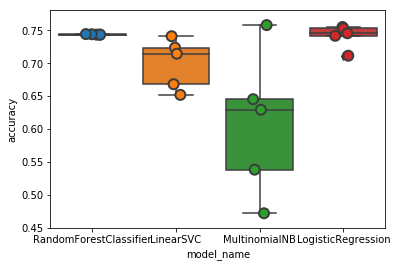

model_name
LinearSVC                 0.700021
LogisticRegression        0.741598
MultinomialNB             0.608607
RandomForestClassifier    0.743974
Name: accuracy, dtype: float64

In [45]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()

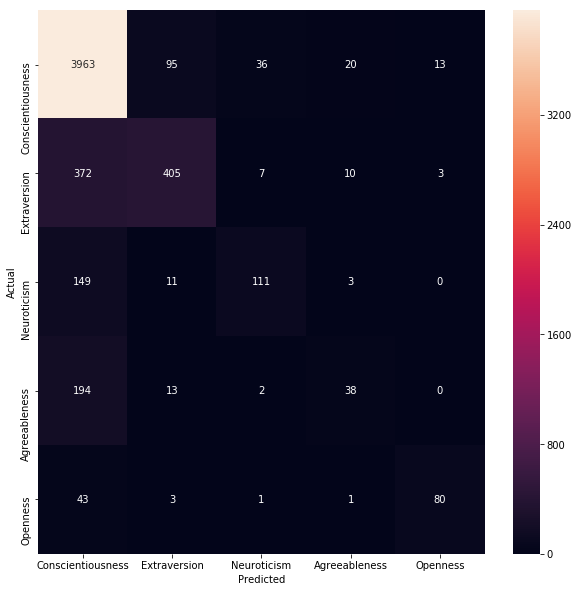

In [48]:
#Change the model as per Accuracy
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Type.values, yticklabels=category_id_df.Type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [308]:
#Chi Square Test

model.fit(features, labels)
N = 5
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# '0':
  . Top unigrams:
       . instafollow
       . instagood
       . venezia
       . tropical
       . instafun
  . Top bigrams:
       . fair berlin
       . saint tropez
       . bar berlin
       . iga 2017
       . instapic instadaily
# '1':
  . Top unigrams:
       . ifa
       . island
       . spain
       . berlinmeetshamburg
       . tulum
  . Top bigrams:
       . fashion fair
       . cannes france
       . panorama fashion
       . instadaily instafun
       . côte azur
# '2':
  . Top unigrams:
       . oodt
       . girl
       . 20likes
       . kenzo
       . thank
  . Top bigrams:
       . cannes france
       . berlin germany
       . party berlin
       . ausstellung berlin
       . genzken ausstellung
# '3':
  . Top unigrams:
       . bestoftheday
       . visiting
       . kadewe
       . beyonce
       . hot
  . Top bigrams:
       . berlin fashion
       . world photography
       . sony world
       . fashion fair
       . igers statigram
# '4':
  . Top uni

In [311]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=str(df['Type'].unique())))

             precision    recall  f1-score   support

          [       0.17      0.15      0.16        79
          4       0.20      0.11      0.14        74
                  0.25      0.14      0.18        92
          1       0.19      0.47      0.27        74
                  0.30      0.22      0.25        88

avg / total       0.23      0.21      0.20       407



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 11
  .format(len(labels), len(target_names))
